## Работа с текстовыми данными

In [20]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import mglearn
import matplotlib.pyplot as plt

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation

### Пример применения: анализ тональности киноотзывов

In [3]:
reviews_train = load_files("C:/Users/Azamind/Downloads/aclImdb/train")
# load_files возвращает коллекцию, содержащую обучающие тексты и обучающие метки
text_train, y_train = reviews_train.data, reviews_train.target
print("тип text_train: {}".format(type(text_train)))
print("длина text_train : {}".format(len(text_train)))
print("text_train[1]:\n{}".format(text_train[1]))

тип text_train: <class 'list'>
длина text_train : 25000
text_train[1]:
b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" shou

In [4]:
# очистим данные от тега <br/>
text_train = [doc.replace(b"<br/>", b" ") for doc in text_train]

In [5]:
# количество положительных и отрицательных отзывов одинаково
print("Количество примеров на класс (обучение): {}".format(np.bincount(y_train)))

Количество примеров на класс (обучение): [12500 12500]


In [6]:
# аналогичным образом загружаем тестовые данные
reviews_test = load_files("C:/Users/Azamind/Downloads/aclImdb/test")
# load_files возвращает коллекцию, содержащую обучающие тексты и обучающие метки
text_test, y_test = reviews_test.data, reviews_test.target
print("Количество документов в текстовых данных: {}".format(len(text_test)))
print("Количество примеров на класс (тест): {}".format(np.bincount(y_test)))
# очистим данные от тега <br/>
text_test = [doc.replace(b"<br/>", b" ") for doc in text_test]

Количество документов в текстовых данных: 25000
Количество примеров на класс (тест): [12500 12500]


### Представление текстовых данных в виде "мешка слов" (bag-of-words)

смотри стр 414 подробно описано

<h4 style="color:green;">Применение модели "мешок слов" к синтетическому набору данных</h4>

In [2]:
# в sklearn модель "мешок слов" реализован в классе CountVecrorizer
# просто пример
bards_words = ["The fool doth think he is wise,", "but the wise man knows himself to be a fool"]
vect = CountVectorizer()
vect.fit(bards_words)
print("Размер словаря: {}".format(len(vect.vocabulary_)))
print("Содержимое словаря:\n{}".format(vect.vocabulary_))

Размер словаря: 13
Содержимое словаря:
{'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [23]:
# теперь, чтобы получить представление "мешок слов" для обуч. данных, достаточно вызвать метод transform
bag_of_words = vect.transform(bards_words)
print("bag of words: {}".format(repr(bag_of_words)))

bag of words: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [24]:
print("Плотное представление bag_of_words:\n{}".format(bag_of_words.toarray()))

Плотное представление bag_of_words:
[[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


<h4 style="color:green;">Модель "мешка слов" для киноотзывов</h4>

In [29]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

X_train:
<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>


In [31]:
# матрица X_train соотвествует обучающим данным
# данные вновь записаны в виде разреженной матрицы SciPy.
# получим доступ к словарю - воспользуемся методом get_feature_names
feature_names = vect.get_feature_names()
print("Количество признаков: {}".format(len(feature_names)))
print("Первые 20 признаков:\n{}".format(feature_names[:20]))
print("Признаки с 20010 по 20030:\n{}".format(feature_names[20010:20030]))
print("Каждый 2000-й признак:\n{}".format(feature_names[::2000]))

Количество признаков: 74849
Первые 20 признаков:
['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
Признаки с 20010 по 20030:
['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
Каждый 2000-й признак:
['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


In [37]:
# проверим модель на верность
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Средняя правильность перекрестной проверки: {:.2f}".format(np.mean(scores)))

Средняя правильность перекрестной проверки: 0.88


In [40]:
# настроим параметр регуляризации C, который можем настроить с помощью перекрестной проверки
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))
print("Наилучшие параметры: {}".format(grid.best_params_))

Наилучшее значение перекрестной проверки: 0.89
Наилучшие параметры: {'C': 0.1}


Используя значение параметра С=0.1, мы получаем значение перекрестной проверки 89%. Теперь можем оценить на тестовом наборе обобщающую способность модели при использовании данного значения параметра её настройки.

In [41]:
X_test = vect.transform(text_test)
print("Правильность на тестовом наборе: {:.3f}".format(grid.score(X_test, y_test)))

Правильность на тестовом наборе: 0.879


In [43]:
# стр 419-420 читать!
# задав значение min_df = 5 уменьшаем количество признаков до 27272
vect = CountVectorizer(min_df=5).fit(text_train)
X_train = vect.transform(text_train)
print("X_train c min_df: {}".format(repr(X_train)))

X_train c min_df: <25000x27272 sparse matrix of type '<class 'numpy.int64'>'
	with 3368680 stored elements in Compressed Sparse Row format>


In [45]:
feature_names = vect.get_feature_names()
print("Первые 50 признаков:\n{}".format(feature_names[:50]))
print("Признаки с 20010 по 20030:\n{}".format(feature_names[20010:20030]))
print("Каждый 700-й признак:\n{}".format(feature_names[::700]))

Первые 50 признаков:
['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
Признаки с 20010 по 20030:
['repent', 'repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete']
Каждый 700-й признак:
['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butcher', 'cheery', 'commit', 'courtroom', 'deconstruct', 'disgraced', 'dvd', 'escapist', 'felix', 'freeze', 'gorier', 'haunts', 'hungarian', 'insincere', 'juggernaut', 'leer', 'mae', 'messes', 'mushy', 'occasion', 'parker', 'pleasantly', 'pronto', 'recipe', 'revie

In [47]:
# оценим качество модели на решетчатом поиске
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("Наилучшее значение перекр проверки: {:.2f}".format(grid.best_score_))

Наилучшее значение перекр проверки: 0.89


### Стоп-слова

In [53]:
# ещё один способ сократь данные - это стоп слова, в sklearn, есть встроенный список англ стоп-слов.
print("Количество сто-слов: {}".format(len(ENGLISH_STOP_WORDS)))
print("Каждое 10-е стоп-слово:\n{}".format(list(ENGLISH_STOP_WORDS)[::10]))

Количество сто-слов: 318
Каждое 10-е стоп-слово:
['next', 'above', 'elsewhere', 'also', 'those', 'namely', 're', 'neither', 'nevertheless', 'below', 'name', 'they', 'much', 'con', 'whereas', 'towards', 'some', 'un', 'whatever', 'well', 'for', 'see', 'there', 'nothing', 'out', 'show', 'go', 'serious', 'never', 'either', 'hundred', 'wherein']


In [54]:
# настройка stop_words="english" задает встроенный список
# стоп-слов. Также можно расширить и передать собственный
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("X_train с использованием стоп-слов: \n{}".format(repr(X_train)))

X_train с использованием стоп-слов: 
<25000x26967 sparse matrix of type '<class 'numpy.int64'>'
	with 2164624 stored elements in Compressed Sparse Row format>


In [56]:
# запустим решетчатый поиск на сокращённых данных стоп-словами
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("Наилучшее значение перекр проверки: {:.2f}".format(grid.best_score_))
# Модель ухудшилась после внедрения стоп-слов. Так, что не смысла его использовать. 
# Его логичнее использовать в маленьком наборе данных.

Наилучшее значение перекр проверки: 0.88


### Масштабирование данных с помощью метода tf-idf

In [8]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(text_train, y_train)
print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))

Наилучшее значение перекрестной проверки: 0.89


In [10]:
# извлекаем из конвейера наилучшую модель, найденную с помощью решетчатого поиска
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# преобразуем обучающий набор данных
X_train = vectorizer.transform(text_train)
# находим максимальное значение каждого признака по набору данных
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# получаем имена признаков
feature_names = np.array(vectorizer.get_feature_names())

print("Признаки с наименьшими значениями tfidf:\n{}".format(feature_names[sorted_by_tfidf[:20]]))
print("Признаки с наибольшими значениями tfidf:\n{}".format(feature_names[sorted_by_tfidf[-20:]]))

Признаки с наименьшими значениями tfidf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Признаки с наибольшими значениями tfidf:
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


In [11]:
# обратная частота документа, наденные для обучающего набора
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Признаки с наименьшими значениями idf:\n{}".format(feature_names[sorted_by_idf[:100]]))

Признаки с наименьшими значениями idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'br' 'have' 'one' 'be' 'film' 'are' 'you'
 'all' 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his'
 'out' 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more'
 'when' 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really'
 'story' 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were'
 'other' 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how'
 'great' 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after'
 'any' 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen'
 'its']


### Исследование коэффициентов модели

На гистограмме показаны 25 наибольших и 25 наименьших коэффициентов модели логистической регрессии, здесь размер каждого столбика соотвествует величине коэффициента.

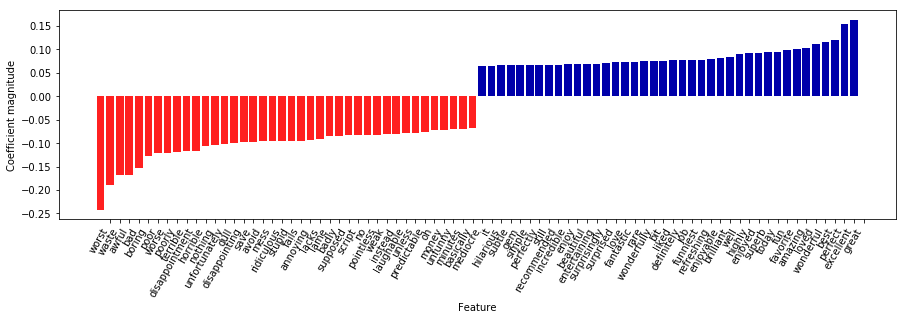

In [15]:
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps["logisticregression"].coef_, feature_names, n_top_features=40)

### Модель "мешка слов" для последовательностей из нескольких слов (n-грамм)

In [6]:
# последовательность из одного токена  - unigramms
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Размеры словаря: {}".format(len(cv.vocabulary_)))
print("Словарь:\n {}".format(cv.get_feature_names()))

Размеры словаря: 13
Словарь:
 ['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [7]:
# чтобы посмотреть на биграммы, т.е последовательность из 2 слов следующим друг за другом
# передадим параметр ngram_range = (2, 2)
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Размеры словаря: {}".format(len(cv.vocabulary_)))
print("Словарь:\n {}".format(cv.get_feature_names()))

Размеры словаря: 14
Словарь:
 ['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [8]:
# больше последовательностей токенов, приводит к гораздо большему числу признаков и детализации
print("Преобразованные данные: \n{}".format(cv.transform(bards_words).toarray()))

Преобразованные данные: 
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [9]:
# использование вместе юниграммы, биграммы, триграммы
cv =  CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Размеры словаря: {}".format(len(cv.vocabulary_)))
print("Словарь:\n {}".format(cv.get_feature_names()))

Размеры словаря: 39
Словарь:
 ['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


In [11]:
# применение модели класса TfidfVectorizer к киноотзывам
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression())
# выполнение программы будет долгим
param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(text_train, y_train)
print("Наилучшее значение перекрестной проверки: {:.2f}".format(grid.best_score_))
print("Наилучшие параметры:\n{}".format(grid.best_params_))

Наилучшее значение перекрестной проверки: 0.91
Наилучшие параметры:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


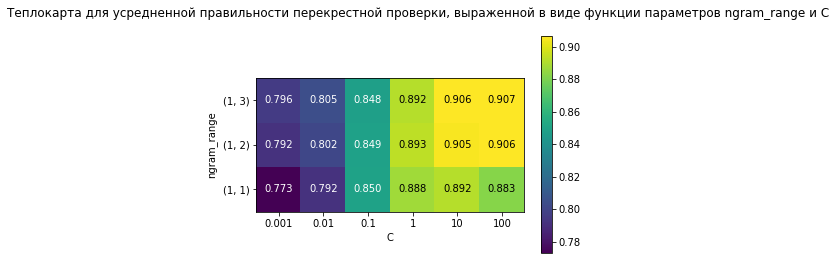

In [14]:
# извлекаем значение правильности, найденные в ходе решетчатого поиска
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# визуализируем теплокарту
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range",
    cmap='viridis', fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)
plt.suptitle("Теплокарта для усредненной правильности перекрестной проверки, выраженной в виде функции параметров ngram_range и С")
plt.show()

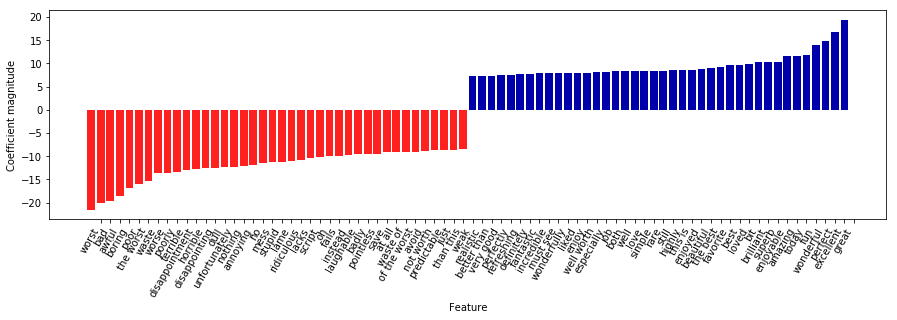

In [15]:
# визуализируем наиболее важные коэффициенты наилучшей модели
# которая включает юниграммы, биограммы и триграммы
# извлекаем название признаков и коэффициенты
vect = grid.best_estimator_.named_steps["tfidfvectorizer"]
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef, feature_names, n_top_features=40)

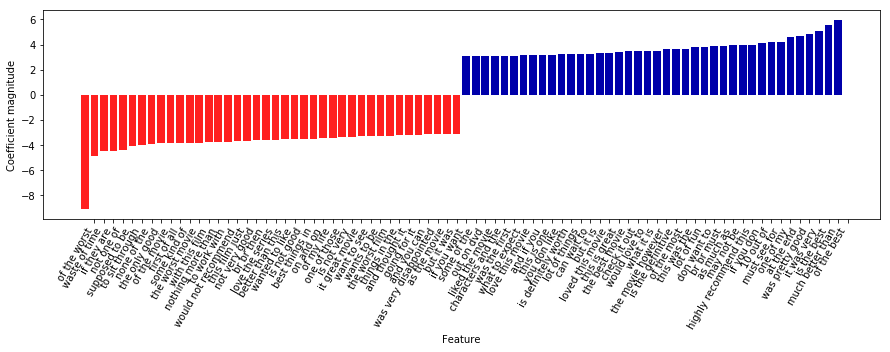

In [16]:
# визуализируем только триграммы, чтобы лучше понять, какие признаки являются полезными
# находим триграммные признаки
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
mglearn.tools.visualize_coefficients(coef.ravel()[mask], feature_names[mask], n_top_features=40)

### Моделирование тем и кластеризация документов.

<h4 style="color: green;">Латентное размещение Дирихле (LDA - Latent Ditichlet Allocation)</h4>

In [17]:
# Удалим слова которые появляются в 15% докуметов
# и ограничим  модель "мешка слов" до 10000 слов, которые представляют собой
# наиболее часто встречающиеся слова
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

Теперь построим ещё одну модель, на этот раз выделив 100 тем. Увелечение значения параметра n_topics в значительной мере усложняет анализ, но при этом повышает вероятность найти с помощью полученных тем интересные подмножества данных.

In [22]:
lda100 = LatentDirichletAllocation(n_topics=100, learning_method="batch", max_iter=25, random_state=0, n_jobs=-1)
document_tipics100 = lda100.fit_transform(X)

In [23]:
# вывод на печать все 100 тем оказалось бы слишком громоздким,
# поэтому выбирим лишь некоторые интересные и характерные темы
topics = np.array([7, 16, 24, 25, 28, 36, 37, 45, 51, 53, 54, 63, 89, 97])
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=topics, feature_names=feature_names, sorting=sorting, topics_per_chunk=7, n_words=20)

topic 7       topic 16      topic 24      topic 25      topic 28      topic 36      topic 37      
--------      --------      --------      --------      --------      --------      --------      
richard       sex           ben           harris        series        musical       documentary   
maria         nothing       feel          robert        episode       dance         footage       
ritter        interesting   audience      check         show          song          lee           
whale         seems         without       dorothy       episodes      songs         earth         
widmark       enough        deep          hudson        season        dancing       animals       
morgan        didn          cube          garbo         fi            singing       nature        
skip          violence      left          sirk          sci           numbers       interviews    
street        anything      care          bacall        tv            music         animal        
fuller    

In [27]:
# сортируем документы по весу темы 36 "музыка"
music = np.argsort(document_tipics100[:, 36]) [::-1]
# печатаем 5 документов, в которых данная тема является наиболее важной
for i in music[:10]:
    # выводим первые 2 предложения
    print(b".".join(text_train[i].split(b".")[:2]) + b".\n")

b"An excellent example of the spectacular Busby Berkeley musicals produced in the early 1930's. Audiences must've been very surprised to see James Cagney in this type of vehicle.\n"
b"Gunga Din (1939) is based on Rudyard Kipling's poem.The movie is directed by George Stevens.\n"
b'This movie will always be a Broadway and Movie classic, as long as there are still people who sing, dance, and act..\n'
b"Such energy and vitality. You just can't go wrong with Busby Berkley films and this certainly must be his best.\n"
b'79/100. Fred Astaire and Ginger Rogers never made anything but great films together.\n'
b'Throughly enjoy all the musical numbers each time I see this movie. Never seem to tire of it.\n'
b'Another good Stooge short!Christine McIntyre is so lovely and evil and the same time in this one!She is such a great actress!The Stooges are very good and especially Shemp and Larry!This to is a good one to watch around Autumn time!.\n'
b'Lots of singing and dancing in this one, especially

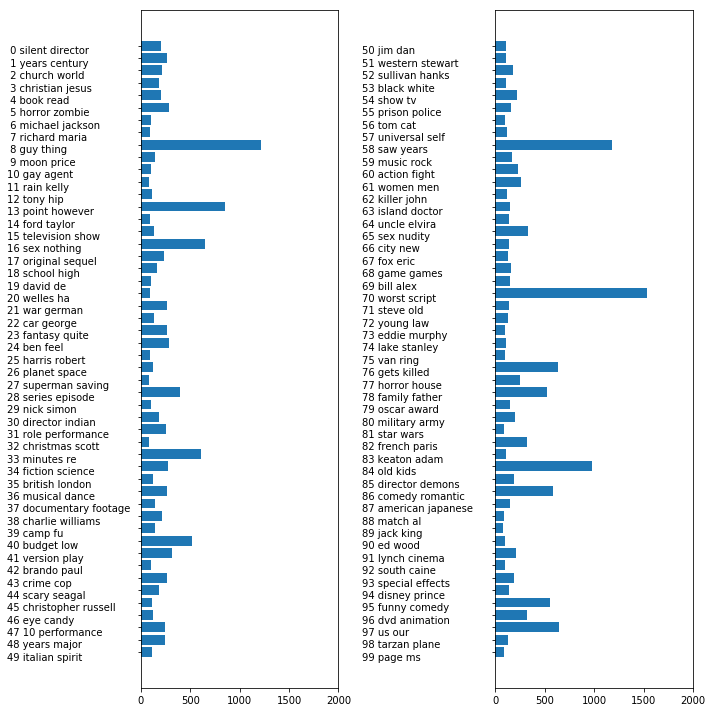

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]
# две столбиковые диаграммы
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_tipics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 2000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()